# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## 共通の関数を定義

In [222]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def build_hamiltonian(mol):
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] # creates Hamiltonian
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    E_HF = myhf.e_tot

    return H_mat, E_fci, E_HF

# mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
# H_mat, E_fci, E_HF = build_hamiltonian(mol)
# print(H_mat)


def FCIQMC(mol, shift=0, init_n_walker=1, n_steps=5000, step_starting_shift_upd=500, shift_upd_interval=10,
           dt=0.001, damping=0.05):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて基底状態エネルギーを推定する。

    Args:
        mol: 分子
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """    
    H_mat, E_fci, E_HF = build_hamiltonian(mol)
    print(f"--- FCI Matrix ---")
    print(H_mat.shape)
    print(H_mat)

    H_mat = H_mat - np.eye(H_mat.shape[0]) * E_HF
    print(f"--- K Matrix ---")
    print(H_mat)
    
    E_est = 0
    hist_population, hist_shift, hist_energy = [], [], []
    
    diag_H = np.diag(H_mat)    
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    walkers = {ref_det_idx: init_n_walker}

    print('\n---- Initial walkers ----')
    for k, v in walkers.items():
        tqdm.write(f"{v} walkers on {k}th determinant")

    
    for step in tqdm(range(n_steps)):
        new_walkers = defaultdict(int)
        
        # walkersが乗っている行列式の全てのインデックスを取得
        current_dets = list(walkers.keys())
        # if step % 1000 == 0:
        #     tqdm.write(f"current_dets: {current_dets}")

        
        for i in current_dets:
            n_i = walkers[i] # ith行列式上のウォーカー数（符号付き）
            if n_i == 0: continue

            # ----- Spawning Step -----
            # 通常は接続された決定基をランダムサンプリングするが、
            # ここでは行列が小さいため、接続している全 j を走査（簡単のため）
            row = H_mat[i]
            # 非ゼロ要素のインデックスを取得
            connected_dets = np.where(row != 0)[0]
            
            for j in connected_dets:
                # 対角要素は自分自身への遷移を表すので処理しない
                if i == j: continue
                h_ij = row[j]

                # Spawning probability: Ps = dt * |H_ij|
                # 生成される数: sign(walker) * sign(-H_ij)
                # TODO: 分母のpgenは1？
                prob_spawn = dt * abs(h_ij)

                # 全てのwalkerに対して、spawnを試みる
                n_spawn = np.full(abs(n_i), 0)
                prob_spawn_frac, prob_spawn_int = math.modf(prob_spawn)
                if prob_spawn_int > 1:
                    n_spawn = np.full(abs(n_i), prob_spawn_int)
                n_spawn += (np.random.rand(abs(n_i)) <= prob_spawn).astype(int)
                
                # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerを遷移先jth行列式の上に生成
                if h_ij > 0:
                    new_walkers[j] += -np.sign(n_i) * np.sum(n_spawn)
                else:
                    new_walkers[j] += np.sign(n_i) * np.sum(n_spawn)


            # ----- Diagonal Step (Death/Cloning) -----
            # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
            h_ii = diag_H[i]
            prob_death = dt * (h_ii - shift)
            n_walker_on_D = n_i
            sign = np.sign(n_walker_on_D)

            # prob_deathの確率でdeath/cloneする（対象となるwalkerの数をカウントする）
            count = np.sum(np.random.rand(abs(n_i)) <= abs(prob_death))
            if prob_death > 0:
                # prob_deathが正ならwalkerをcount分消滅させる
                n_walker_on_D = sign * (abs(n_walker_on_D) - count)
            else:
                # prob_deathが負ならwalkerをcount分複製する
                n_walker_on_D = sign * (abs(n_walker_on_D) + count)    
            walkers[i] = n_walker_on_D
            

        # ----- Annihilation Step -----
        for idx, n in new_walkers.items():
            walkers[idx] = walkers.get(idx, 0) + n

        # ---- Shift Update -----
        current_pop = sum(abs(w) for w in walkers.values())
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift
        hist_shift.append(shift)
        pre_pop = current_pop
        hist_population.append(current_pop)
        
        # ----- Energy Estimation (Projected Energy) -----
        # E_HF2 = diag_H[ref_det_idx]  # TODO: これはE_HFではない
        row0 = H_mat[ref_det_idx]
        num_ref = walkers.get(ref_det_idx, 0)
        E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        # TODO: 論文にはない項を足している
        # E_proj += mol.energy_nuc()
        hist_energy.append(E_proj)
        # TODO: singles/doublesに限定する？
        
        if step % 1000 == 0:
            tqdm.write(f"Step {step}: Walkers={current_pop}, Shift={shift:.5f}, E_proj={E_proj:.6f}")
            for k, v in walkers.items():
                if v != 0:
                    tqdm.write(f"  {v} walkers on {k}th determinant")

    E_est = np.mean(hist_energy[-1000:]) # 最後の1000ステップの平均
    
    print('\n---- Walkers (result) ----')
    for k, v in walkers.items():
        if v != 0:
            print(f"{v} walkers on {k}th determinant")

    return E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy


def plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_population)
    plt.xlabel('Step')
    plt.ylabel('Population')
    plt.yscale('log')

    E_corr = np.full_like(hist_shift, E_fci - E_HF)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_shift, label="Shift")
    plt.plot(E_corr, linestyle="--", label=r"${E_{corr}}$")
    plt.xlabel('Step')
    plt.ylabel('Shift')
    plt.legend()

    E_fci_arr = np.full_like(hist_energy, E_fci)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_energy, label=r"${E_{proj}}$")
    plt.plot(E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
    plt.xlabel('Step')
    plt.ylabel('Projected Energy')
    plt.legend()
    
    plt.show()

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは近い値が出るが、Shiftが下がり続け、${E_{corr}}$の値に収束しない（原因不明）。

--- FCI Matrix ---
(4, 4)
[[-1.83186365 -0.         -0.          0.18121046]
 [-0.         -1.06466723  0.18121046  0.        ]
 [-0.          0.18121046 -1.06466723  0.        ]
 [ 0.18121046  0.          0.         -0.25248619]]
--- K Matrix ---
[[-0.71510434 -0.         -0.          0.18121046]
 [-0.          0.05209207  0.18121046  0.        ]
 [-0.          0.18121046  0.05209207  0.        ]
 [ 0.18121046  0.          0.          0.86427311]]

---- Initial walkers ----
10 walkers on 0th determinant


  6%|█████▋                                                                                    | 1906/30000 [00:00<00:01, 19053.89it/s]

Step 0: Walkers=11, Shift=0.00000, E_proj=-1.116759
  11 walkers on 0th determinant
Step 1000: Walkers=18, Shift=0.00000, E_proj=-1.153001
  15 walkers on 0th determinant
  -3 walkers on 3th determinant
Step 2000: Walkers=30, Shift=0.00000, E_proj=-1.144638
  26 walkers on 0th determinant
  -4 walkers on 3th determinant
Step 3000: Walkers=72, Shift=0.00000, E_proj=-1.133233
  66 walkers on 0th determinant
  -6 walkers on 3th determinant


 19%|█████████████████                                                                         | 5667/30000 [00:00<00:01, 18097.98it/s]

Step 4000: Walkers=165, Shift=0.00000, E_proj=-1.137574
  148 walkers on 0th determinant
  -17 walkers on 3th determinant
Step 5000: Walkers=358, Shift=0.00000, E_proj=-1.137646
  321 walkers on 0th determinant
  -37 walkers on 3th determinant
Step 6000: Walkers=763, Shift=0.00000, E_proj=-1.140081
  676 walkers on 0th determinant
  -87 walkers on 3th determinant
Step 7000: Walkers=1527, Shift=0.00000, E_proj=-1.137673
  1369 walkers on 0th determinant
  -158 walkers on 3th determinant


 30%|███████████████████████████▎                                                              | 9097/30000 [00:00<00:01, 11883.18it/s]

Step 8000: Walkers=3265, Shift=0.00000, E_proj=-1.137754
  2926 walkers on 0th determinant
  -339 walkers on 3th determinant
Step 9000: Walkers=5861, Shift=-0.30158, E_proj=-1.137005
  5272 walkers on 0th determinant
  -589 walkers on 3th determinant


 35%|███████████████████████████████▏                                                          | 10416/30000 [00:00<00:02, 8599.37it/s]

Step 10000: Walkers=8338, Shift=-0.44471, E_proj=-1.138032
  7462 walkers on 0th determinant
  -876 walkers on 3th determinant


 38%|██████████████████████████████████▎                                                       | 11457/30000 [00:01<00:02, 6770.44it/s]

Step 11000: Walkers=10315, Shift=-0.55991, E_proj=-1.135847
  9332 walkers on 0th determinant
  -983 walkers on 3th determinant


 41%|████████████████████████████████████▊                                                     | 12290/30000 [00:01<00:03, 5799.19it/s]

Step 12000: Walkers=12001, Shift=-0.62503, E_proj=-1.137716
  10757 walkers on 0th determinant
  -1244 walkers on 3th determinant


 45%|████████████████████████████████████████▋                                                 | 13564/30000 [00:01<00:03, 4684.44it/s]

Step 13000: Walkers=13079, Shift=-0.66720, E_proj=-1.136981
  11766 walkers on 0th determinant
  -1313 walkers on 3th determinant


 48%|███████████████████████████████████████████▌                                              | 14526/30000 [00:02<00:03, 4065.10it/s]

Step 14000: Walkers=13816, Shift=-0.69575, E_proj=-1.137143
  12419 walkers on 0th determinant
  -1397 walkers on 3th determinant


 51%|██████████████████████████████████████████████                                            | 15336/30000 [00:02<00:03, 3694.65it/s]

Step 15000: Walkers=14222, Shift=-0.70855, E_proj=-1.136608
  12818 walkers on 0th determinant
  -1404 walkers on 3th determinant


 55%|█████████████████████████████████████████████████▏                                        | 16391/30000 [00:02<00:04, 3374.45it/s]

Step 16000: Walkers=14552, Shift=-0.71453, E_proj=-1.136998
  13090 walkers on 0th determinant
  -1462 walkers on 3th determinant


 58%|████████████████████████████████████████████████████▏                                     | 17380/30000 [00:02<00:03, 3243.98it/s]

Step 17000: Walkers=14857, Shift=-0.71728, E_proj=-1.137533
  13329 walkers on 0th determinant
  -1528 walkers on 3th determinant


 61%|██████████████████████████████████████████████████████▉                                   | 18323/30000 [00:03<00:03, 3061.32it/s]

Step 18000: Walkers=15095, Shift=-0.72362, E_proj=-1.137347
  13555 walkers on 0th determinant
  -1540 walkers on 3th determinant


 65%|██████████████████████████████████████████████████████████▋                               | 19565/30000 [00:03<00:03, 2997.09it/s]

Step 19000: Walkers=15128, Shift=-0.72826, E_proj=-1.136557
  13638 walkers on 0th determinant
  -1490 walkers on 3th determinant


 68%|█████████████████████████████████████████████████████████████▍                            | 20493/30000 [00:03<00:03, 3041.15it/s]

Step 20000: Walkers=15306, Shift=-0.72660, E_proj=-1.137251
  13751 walkers on 0th determinant
  -1555 walkers on 3th determinant


 71%|████████████████████████████████████████████████████████████████▎                         | 21421/30000 [00:04<00:02, 3076.69it/s]

Step 21000: Walkers=15432, Shift=-0.73828, E_proj=-1.138219
  13798 walkers on 0th determinant
  -1634 walkers on 3th determinant


 74%|███████████████████████████████████████████████████████████████████                       | 22338/30000 [00:04<00:02, 2996.98it/s]

Step 22000: Walkers=15360, Shift=-0.74118, E_proj=-1.137933
  13753 walkers on 0th determinant
  -1607 walkers on 3th determinant


 79%|██████████████████████████████████████████████████████████████████████▊                   | 23589/30000 [00:05<00:02, 3098.98it/s]

Step 23000: Walkers=15277, Shift=-0.73722, E_proj=-1.137368
  13717 walkers on 0th determinant
  -1560 walkers on 3th determinant


 82%|█████████████████████████████████████████████████████████████████████████▌                | 24509/30000 [00:05<00:01, 3000.87it/s]

Step 24000: Walkers=15286, Shift=-0.73165, E_proj=-1.137428
  13721 walkers on 0th determinant
  -1565 walkers on 3th determinant


 85%|████████████████████████████████████████████████████████████████████████████▎             | 25428/30000 [00:05<00:01, 3010.74it/s]

Step 25000: Walkers=15398, Shift=-0.73878, E_proj=-1.138169
  13771 walkers on 0th determinant
  -1627 walkers on 3th determinant


 88%|██████████████████████████████████████████████████████████████████████████████▉           | 26330/30000 [00:05<00:01, 2960.66it/s]

Step 26000: Walkers=15314, Shift=-0.73163, E_proj=-1.137636
  13732 walkers on 0th determinant
  -1582 walkers on 3th determinant


 92%|██████████████████████████████████████████████████████████████████████████████████▋       | 27563/30000 [00:06<00:00, 3059.69it/s]

Step 27000: Walkers=15213, Shift=-0.74570, E_proj=-1.137140
  13675 walkers on 0th determinant
  -1538 walkers on 3th determinant


 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 28513/30000 [00:06<00:00, 3119.35it/s]

Step 28000: Walkers=15060, Shift=-0.74041, E_proj=-1.136523
  13579 walkers on 0th determinant
  -1481 walkers on 3th determinant


 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 29455/30000 [00:06<00:00, 3091.53it/s]

Step 29000: Walkers=15003, Shift=-0.73710, E_proj=-1.136265
  13545 walkers on 0th determinant
  -1458 walkers on 3th determinant


100%|██████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:07<00:00, 4219.26it/s]



---- Walkers (result) ----
13534 walkers on 0th determinant
-1534 walkers on 3th determinant
E_fci=-1.137283834488502, E_HF=-1.1167593073964248
------------------------------
FCI Energy: -1.137284 Ha
Final FCIQMC Energy: -1.137180 Ha


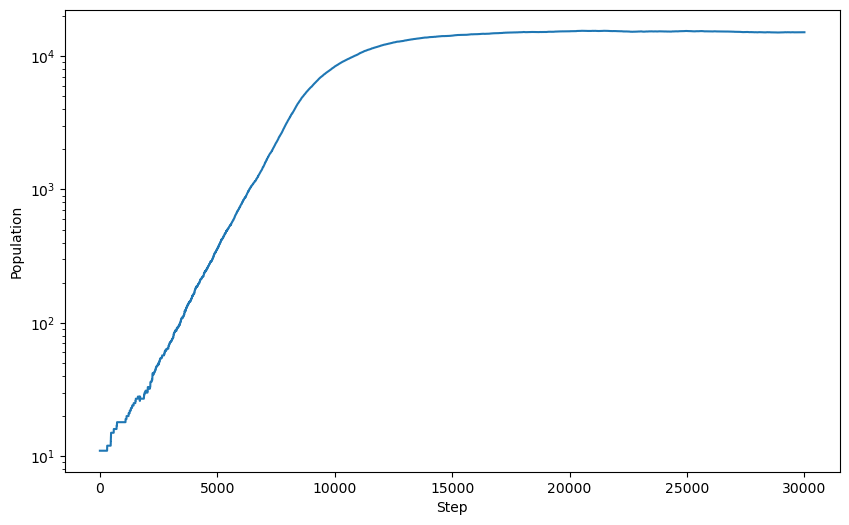

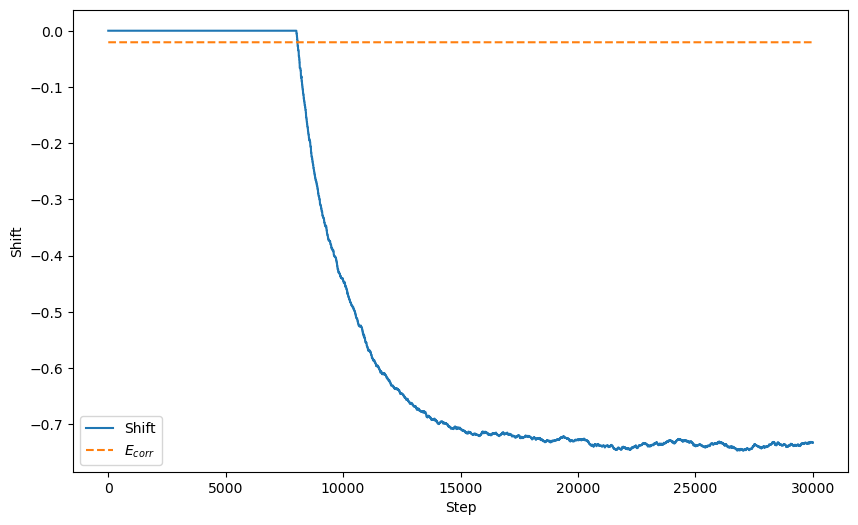

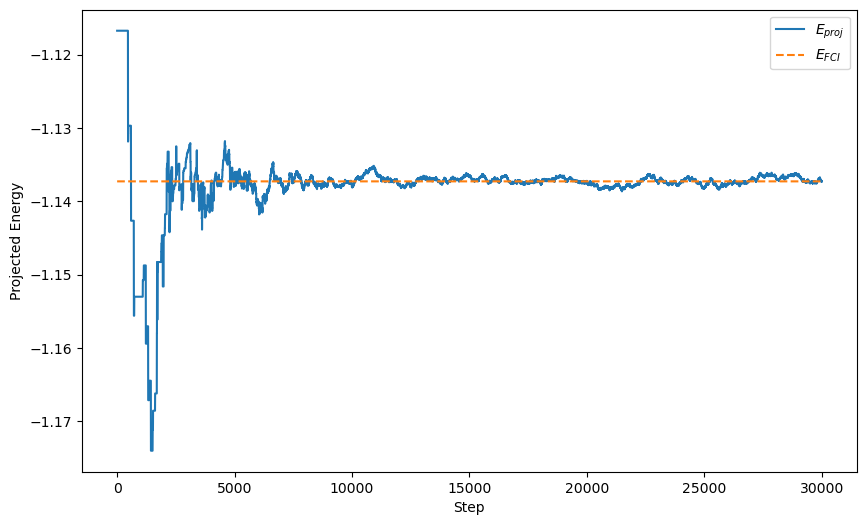

In [225]:
from pyscf import gto

# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, init_n_walker=10, n_steps=30000, step_starting_shift_upd=8000)

print(f"E_fci={E_fci}, E_HF={E_HF}")

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${H_3^+}$ (sto-3g)
FCI行列は9x9

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
--- FCI Matrix ---
(9, 9)
[[-2.83347005  0.         -0.00000001  0.          0.14407645 -0.         -0.00000001 -0.          0.14407657]
 [ 0.         -2.20370352 -0.          0.14407645  0.         -0.09564372 -0.         -0.09564408 -0.        ]
 [-0.00000001 -0.         -2.20368581 -0.         -0.09564372 -0.          0.14407657 -0.          0.09563962]
 [ 0.          0.14407645 -0.         -2.20370352  0.         -0.09564408 -0.         -0.09564372 -0.        ]
 [ 0.14407645  0.         -0.09564372  0.         -1.47385244 -0.         -0.09564372 -0.          0.07588714]
 [-0.         -0.09564372 -0.         -0.09564408 -0.         -1.62560526 -0.          0.07588714 -0.        ]
 [-0.00000001 -0.          0.14407657 -0.         -0.09564372 -0.         -2.20368581 -0.          0.09563962]
 [-0.         -0.09564408 -0.       

  7%|██████▋                                                                                   | 1477/20000 [00:00<00:01, 14763.92it/s]

Step 0: Walkers=1, Shift=0.00000, E_proj=-1.245915
  1 walkers on 0th determinant
Step 1000: Walkers=2, Shift=0.00000, E_proj=-1.245915
  2 walkers on 0th determinant
Step 2000: Walkers=16, Shift=0.00000, E_proj=-1.266497
  14 walkers on 0th determinant
  -2 walkers on 8th determinant


 15%|█████████████▎                                                                            | 2954/20000 [00:00<00:01, 10081.89it/s]

Step 3000: Walkers=75, Shift=0.00000, E_proj=-1.268081
  65 walkers on 0th determinant
  -6 walkers on 4th determinant
  -4 walkers on 8th determinant


 20%|██████████████████▍                                                                        | 4048/20000 [00:00<00:02, 7008.21it/s]

Step 4000: Walkers=380, Shift=0.00000, E_proj=-1.277724
  308 walkers on 0th determinant
  4 walkers on 2th determinant
  -42 walkers on 4th determinant
  -26 walkers on 8th determinant


 27%|█████████████████████████                                                                  | 5498/20000 [00:00<00:03, 4482.76it/s]

Step 5000: Walkers=1918, Shift=0.00000, E_proj=-1.273810
  1596 walkers on 0th determinant
  8 walkers on 2th determinant
  -180 walkers on 4th determinant
  -5 walkers on 6th determinant
  -129 walkers on 8th determinant


 30%|███████████████████████████▎                                                               | 6007/20000 [00:01<00:04, 3432.08it/s]

Step 6000: Walkers=9562, Shift=0.00000, E_proj=-1.275526
  7897 walkers on 0th determinant
  7 walkers on 2th determinant
  -842 walkers on 4th determinant
  -35 walkers on 6th determinant
  -781 walkers on 8th determinant


 35%|███████████████████████████████▋                                                           | 6960/20000 [00:02<00:08, 1534.81it/s]

Step 7000: Walkers=33326, Shift=-0.63645, E_proj=-1.274385
  27793 walkers on 0th determinant
  1 walkers on 2th determinant
  -2757 walkers on 4th determinant
  -40 walkers on 6th determinant
  -2735 walkers on 8th determinant


 40%|████████████████████████████████████▉                                                       | 8034/20000 [00:04<00:33, 352.62it/s]

Step 8000: Walkers=72069, Shift=-1.02318, E_proj=-1.274189
  60191 walkers on 0th determinant
  -3 walkers on 2th determinant
  -5931 walkers on 4th determinant
  -63 walkers on 6th determinant
  -5881 walkers on 8th determinant


 45%|█████████████████████████████████████████▌                                                  | 9037/20000 [00:08<00:54, 201.48it/s]

Step 9000: Walkers=115253, Shift=-1.25807, E_proj=-1.273914
  96412 walkers on 0th determinant
  66 walkers on 2th determinant
  -9329 walkers on 4th determinant
  -39 walkers on 6th determinant
  -9407 walkers on 8th determinant


 50%|█████████████████████████████████████████████▌                                             | 10025/20000 [00:14<01:05, 152.71it/s]

Step 10000: Walkers=153367, Shift=-1.39877, E_proj=-1.274373
  128018 walkers on 0th determinant
  44 walkers on 2th determinant
  -12435 walkers on 4th determinant
  -19 walkers on 6th determinant
  -12851 walkers on 8th determinant


 55%|██████████████████████████████████████████████████▏                                        | 11023/20000 [00:21<01:09, 128.44it/s]

Step 11000: Walkers=182103, Shift=-1.48466, E_proj=-1.274337
  152064 walkers on 0th determinant
  -4 walkers on 2th determinant
  -14828 walkers on 4th determinant
  -37 walkers on 6th determinant
  -15170 walkers on 8th determinant


 60%|██████████████████████████████████████████████████████▋                                    | 12019/20000 [00:29<01:08, 116.53it/s]

Step 12000: Walkers=201055, Shift=-1.54087, E_proj=-1.274285
  167961 walkers on 0th determinant
  -5 walkers on 2th determinant
  -16502 walkers on 4th determinant
  16 walkers on 6th determinant
  -16571 walkers on 8th determinant


 65%|███████████████████████████████████████████████████████████▏                               | 13015/20000 [00:38<01:03, 110.04it/s]

Step 13000: Walkers=213393, Shift=-1.57178, E_proj=-1.274259
  178234 walkers on 0th determinant
  -64 walkers on 2th determinant
  -17603 walkers on 4th determinant
  -31 walkers on 6th determinant
  -17461 walkers on 8th determinant


 70%|███████████████████████████████████████████████████████████████▊                           | 14011/20000 [00:47<00:58, 103.06it/s]

Step 14000: Walkers=221009, Shift=-1.58989, E_proj=-1.274412
  184377 walkers on 0th determinant
  -91 walkers on 2th determinant
  -18332 walkers on 4th determinant
  -73 walkers on 6th determinant
  -18136 walkers on 8th determinant


 75%|████████████████████████████████████████████████████████████████████▎                      | 15012/20000 [00:57<00:47, 104.24it/s]

Step 15000: Walkers=225412, Shift=-1.60229, E_proj=-1.274475
  188002 walkers on 0th determinant
  -94 walkers on 2th determinant
  -18790 walkers on 4th determinant
  49 walkers on 6th determinant
  -18477 walkers on 8th determinant


 80%|████████████████████████████████████████████████████████████████████████▊                  | 16013/20000 [01:06<00:38, 102.33it/s]

Step 16000: Walkers=227659, Shift=-1.61048, E_proj=-1.274369
  189971 walkers on 0th determinant
  -128 walkers on 2th determinant
  -18749 walkers on 4th determinant
  -42 walkers on 6th determinant
  -18769 walkers on 8th determinant


 85%|█████████████████████████████████████████████████████████████████████████████▍             | 17015/20000 [01:16<00:29, 100.66it/s]

Step 17000: Walkers=228766, Shift=-1.61366, E_proj=-1.274544
  190641 walkers on 0th determinant
  -141 walkers on 2th determinant
  -18705 walkers on 4th determinant
  103 walkers on 6th determinant
  -19176 walkers on 8th determinant


 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 18016/20000 [01:26<00:19, 103.92it/s]

Step 18000: Walkers=229173, Shift=-1.61346, E_proj=-1.274277
  191350 walkers on 0th determinant
  19 walkers on 2th determinant
  -18717 walkers on 4th determinant
  136 walkers on 6th determinant
  -18951 walkers on 8th determinant


 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 19015/20000 [01:36<00:09, 98.60it/s]

Step 19000: Walkers=229756, Shift=-1.61261, E_proj=-1.274327
  191844 walkers on 0th determinant
  -51 walkers on 2th determinant
  -19052 walkers on 4th determinant
  30 walkers on 6th determinant
  -18779 walkers on 8th determinant


100%|███████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:45<00:00, 188.79it/s]



---- Walkers (result) ----
192331 walkers on 0th determinant
-57 walkers on 2th determinant
-18979 walkers on 4th determinant
-24 walkers on 6th determinant
-18964 walkers on 8th determinant
------------------------------
FCI Energy: -1.274275 Ha
Final FCIQMC Energy: -1.274325 Ha


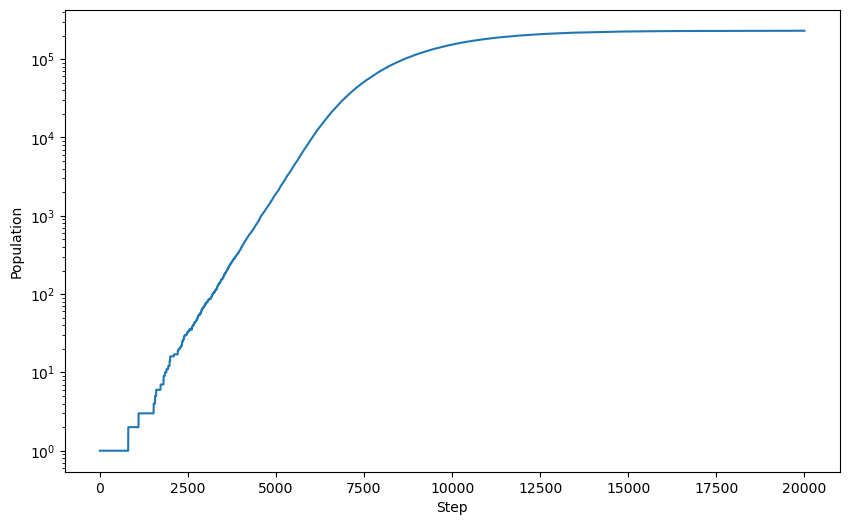

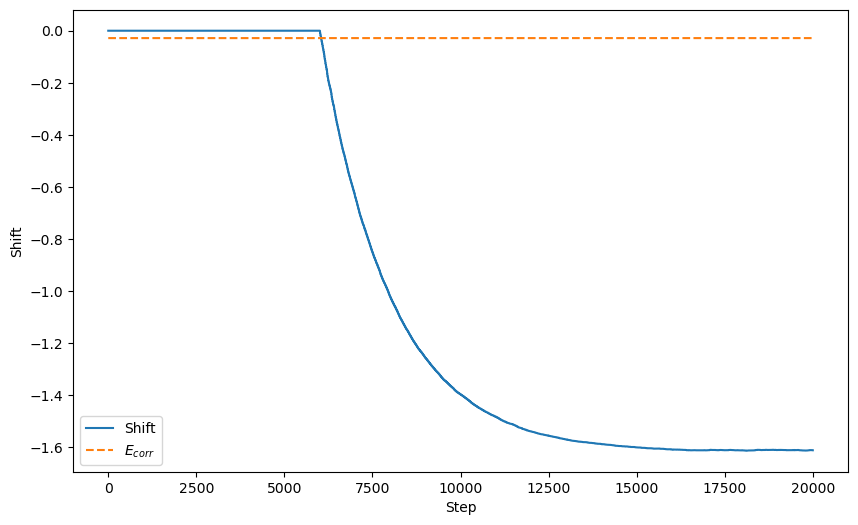

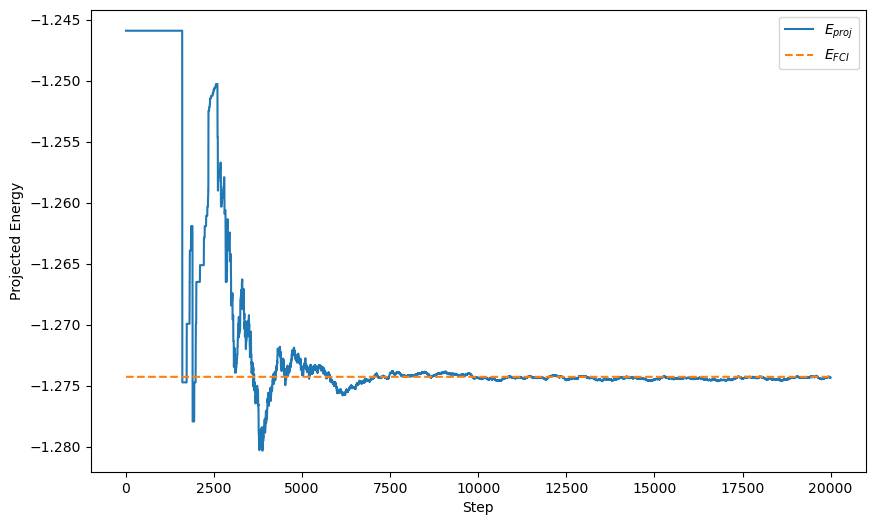

In [221]:
from pyscf import gto

# H3+分子の定義
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=15000, step_starting_shift_upd=4000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)
